### 30/11/2022 - PC8/DM - PHY550

### The code works with 3 noble gases (Ar, Kr, Xe)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('../')
from LPP0D import *
from scipy.constants import k, e, m_e, epsilon_0, c,m_p
from scipy.special import jv
from tqdm import tqdm

#plt.style.use('./rcparams.mplstyle')

In [2]:
## Propellant choice : xenon, krypton or argon
gas = 'argon'

## Generated_file created
gen_diff_all_gases('input_{}.txt'.format(gas))


generated_diff_all_gases.py est ok!


In [3]:
## Objects creation : thruster, params, chem 
my_objects = generate_all_objects('input_{}.txt'.format(gas))

thruster = my_objects[0]
params = my_objects[1]
chem = my_objects[2]

init = chem.init_vector

# Objects inspection

In [4]:
verbose = True

if verbose:
    print(thruster)
    print(params)

    for a in chem.R.keys():
        for b in chem.R[a].keys():
            for d in chem.R[a][b].keys():
                print(d[:5])
                print(chem.R[a][b][d])
#                  pass

The thruster's parameters are:
    R = 0.06 m
    L = 0.1 m
    R_coil = 2 Ohm
    w = 85199992.76535518 Hz
    N = 6 
    Vgrids = 1000 V
    grid_dist = 0.001 m
    r_coil = 0.065 m
    l_coil = 0.1 m
    beta_neutrals = 0.3 
    beta_ions = 0.7 


The parameters are: 
    Q0 = 1.12e+19 persecond
    Q0 = 2.50e+01 sccm
    Pabs = 1.50e+05 W/m3
    I_coil = 5.00e+00 A
    gamma = 0.02
    T_wall = 300.0 K
    sigma = 1.0e-18 m2
IONIZ
Reaction description:
    [['Ar', 'e^-'], ['Ar^+', 'e^-', 'e^-'], 'IONIZATION']
    \\wsl.localhost\Ubuntu\home\hugon\Projects\Plasma_Physics\Plasma_Propulsor\src\LPP0D/../lxcat/Ar_e_IONIZATION_rates_and_energy.csv
    UQ coef: 1    K(3ev): 1.8662876763077705e-16
ELAST
Reaction description:
    [['Ar', 'e^-'], ['Ar', 'e^-'], 'ELASTIC']
    \\wsl.localhost\Ubuntu\home\hugon\Projects\Plasma_Physics\Plasma_Propulsor\src\LPP0D/../lxcat/Ar_e_ELASTIC_rates_and_energy.csv
    UQ coef: 1    K(3ev): 9.427322403834042e-14
EXCIT
Reaction description:
    [['Ar', 'e^

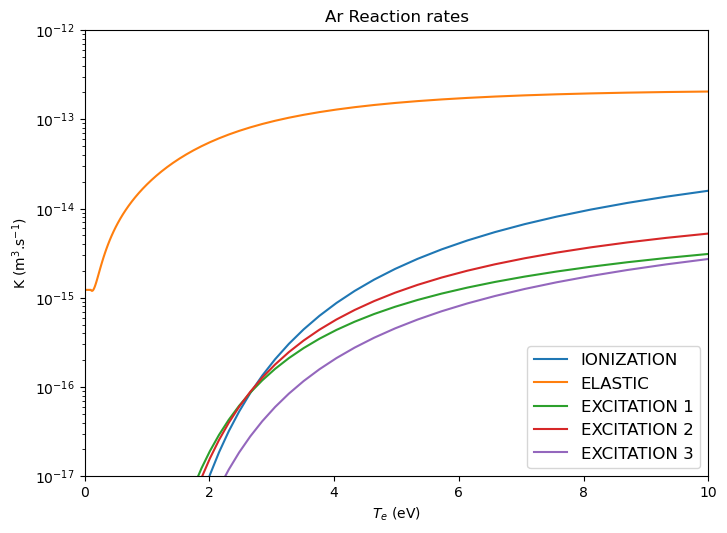

In [5]:
# print the rates used 

species = list_of_species('input_{}.txt'.format(gas))

fig, ax = plt.subplots(figsize=(7,5))
main_element = [a for a in chem.R.keys()][0]

ax.set_yscale('log')
plt.tight_layout()
ax.set_ylim([1e-17, 1e-12])
ax.set_xlim([0,10])


ax.set_yticks([1e-17,1e-16,1e-15,1e-14,1e-13,1e-12])
ax.set_xlabel('$T_e$ (eV)')
ax.set_ylabel('K (m$^3$.s$^{-1}$)') 

if main_element == 'Ar':
    LABELS=['IONIZATION','ELASTIC','EXCITATION 1','EXCITATION 2','EXCITATION 3']
else:
    LABELS=['IONIZATION','ELASTIC','EXCITATION 1','EXCITATION 2','EXCITATION 3','EXCITATION 4']

Te_range = np.logspace(-2, 1,100)
compteur=0
for a in chem.R.keys():
    for b in chem.R[a].keys():
        for c in chem.R[a][b].keys():
            if 'e^-' in chem.R[a][b][c].reactants:
                ax.plot(Te_range, chem.R[a][b][c].K(Te_range), label= '%s'%LABELS[compteur])
                compteur+=1
                
ax.legend(fontsize=12,ncol=1,loc='lower right')
ax.set_title(main_element+' Reaction rates')
plt.show()

#ax.grid()

## Definitions

### Upper bound on the current density

The Child-Langmuir law imposes an upper bound on the maximum current one can extract when two plane grids face each other at a distance $d$ with a difference of potential $V_0$. The maximum stationary current density is: $\boxed{J_{CL}=\frac{4\epsilon_0}{9}\sqrt{\frac{2e}{m}}\frac{V_0^{3/2}}{d^2}}$, where $m$ is the mass of the species considered. Only electrons are concerned by this limitation: $J_e=J_{CL}$. They are supposed to arrive with a negligible speed.

On the edge, ion must come at Bohm speed $u_B$ to maintain a stationnary flow in the space sheat. Therefore, $J_i=n_{\text{edge}} u_B=h_Ln_{i0} u_B$.

The $h_L$ factor is the ion density ratio between the thruster center and its edge; $h_L=\frac{n_{\text{edge}}}{n_{i0}}$. The center of thruster's chamber serves as a location of reference because this is where the approximation of a thermodynamic equilibrium is the most valid.

### Thrust

The treatment is different depending on the physics considered. We first take a purely hydrodynamical point of view.

Recall Euler's theorem:
For a stationary fluid without force density, in an arbitrary domain $\Omega$:
$$
\int_{\partial \Omega} \rho u (u \cdot n) \, dx = \int_{\partial \Omega} \sigma \cdot n \, dx
$$

Assuming no viscosity on the boundary, that is $\sigma = -p \mathbb{1}$ on $\partial \Omega$, the thrust exerced on a nozzle of outlet section $A$ is: $T=\dot m (V_f - V_i)$, where $\dot m$ is the mass flow rate, and $V_f$, $V_i$ are respectively the fluid's velocity upstream and downstream. If the velocity distribution follows Boltzmann's law with mean velocity $\bar v$, the flux going through a section of area $A$ in one direction is $\Gamma=\frac{n \bar v A}{4}$. In a stationary gas flow, the flux is converved. To keep a valid equilibrium hypothesis, the flus is estimated just before the nozzle's entrance, where the fluid has a mean velocity $V_i$. Consider a fluid $g$ such that $V_f \gg V_i$. The thrust admits the simple expression:
$$
T=\frac{m_{\text{g}} n_{g} V_i A }{4}V_f.
$$
$m_g$ is the mass of a single fluid particle and $n_g$ is the gas density just before the nozzle.

- In the case of ions, $V_i=u_B$, $n_g=h_L n_{i0}$, $V_f=\sqrt{\frac{2e\Delta V}{m_i}}$ by electrostatic acceleration. The thrust is:
$$
T_i=\frac{m_{\text{i}} \overbrace{n_{i0} h_L u_B}^{J_i} A }{4}\sqrt{\frac{2e\Delta V}{m_i}}.
$$
The power to accelerate ions is $P_i=J_i \times A \times \Delta V$.

- For a neutral gas, $V_i=V_f=\sqrt{\frac{k_B T}{m}}$. There is not any electrostatic acceleration. The thrust is:
$$
T_g=\frac{m_{\text{g}} n_{g} A }{4}\frac{k_B T}{m_g}.
$$
The thrust power is naturally: $P_g=T_g\times V_f=\frac12 \frac{m_{\text{g}} n_{g} A }{4}\big(\frac{k_B T}{m_g}\big)^{3/2}$

### 

# Useful functions

In [6]:
from scipy.constants import m_e, m_u, k, c, e, epsilon_0

m_Ar=39.95*m_u
m_Xe=131.293*m_u
m_Kr=83.798*m_u

def Jcl(mass,Voltage,distance_grids):
    """Child-Langmuir current (A/m2)
    INPUT : atomic mass, Acceleration voltage, distance between grids
    """
    return 4/9*epsilon_0*np.sqrt(e*2/mass)*Voltage**1.5/distance_grids**2


def R_coil(I):
    """ Coil resistance (Ohm)
    INPUT : I_coil 
    """
    return 2

def J_i(L, R, ng, ne, nIm, Te, Tg, n_ion, part):
    """Ion current (A/m2)
    INPUT : L, R, ng, ne, nIm, Te, Tg, n_ion, particle
    """
    hL = hl(L,ng,ne,nIm,Te,Tg,1e-18)                    # h factor. It is the density ratio between the edge and center of thruster.
    
    return e * n_ion * hL * uB_GRONDEIN(Te,part)

def thrust_neutrals(ng,Tg,part):
    """Neutrals thrust (mN)
    INPUT : ng, Tg, particle
    """
    v_mean_gas = v_th(Tg, part)                   # Thermal speed  
    GammaG = 0.25 * ng * v_mean_gas               # neutral flux 
    Ag = thruster.open_area_neutrals()            # Open area for neutrals
    return GammaG * mass(part) * v_mean_gas * Ag 

def thrust_ions(L, R, ng, ne, nIm, Te, Tg, n_part, part):
    """Thrust from the ions (mN)
    INPUT : L, R, ng, ne, nIm, Te, Tg, n_part, part
    """
    M = mass(part)
    v_beam = np.sqrt(2 * e * thruster.Vgrids / M)                         # Beam speed
    Gammai = n_part * hl(L,ng,ne,nIm,Te,Tg,1e-18) * uB_GRONDEIN(Te,part)  # Ion flux
    Ai = thruster.open_area_ions()                                        # Open area for ions
    return Gammai * M * v_beam * Ai

def IonThrustpower(L, R, ng, ne, nIm, Te, Tg, n_part, part):
    """Power used to accelerate ions: ion current times acceleration voltage.
    INPUT : L, R, ng, ne, nIm, Te, Tg, n_part, part
    """
    return J_i(L, R, ng, ne, nIm, Te, Tg, n_part, part) * thruster.open_area_ions() * thruster.Vgrids


def NeutralThrustpower(ng,Tg,part):
    """Power used to accelerate neutrals
    INPUT : ng, Tg, part
    """
    v_mean_gas = v_th(Tg, part)                                  # Thermal speed of the particle 'part'
    GammaG = 0.25 * ng * v_mean_gas                              # neutral flux 
    Ag = thruster.open_area_neutrals()                           # Open area for neutrals
    return 0.5 * mass(part) * GammaG * v_mean_gas**2 * Ag

# Run with temporal resolution

In [7]:
## Here the solver is called to run the simulation
results = solve_all_gases(thruster, params, chem, init, temporal=True)

In [8]:
main_element = [a for a in chem.R.keys()][0]
print('The propellant used is :',main_element)
species = list_of_species('input_{}.txt'.format(gas))
print('The species considered are :',species)

n_e = results.y[0]             # Electron density versus time         (m-3)
n_g = results.y[1]             # Gas density versus time              (m-3)
n_i = results.y[2]             # Ion density versus time              (m-3)
T_e = results.y[3]             # Electron temperature versus time     (eV) 
T_g = results.y[4]             # Gas temperature versus time          (eV)
res = results.y[:,-1]          # List of the last simulated physical quantities (n_e[-1], n_g[-1], n_i[-1], T_e[-1], T_g[-1])

R_induction = R_ind_noble_gas(n_e[-1],n_g[-1],
                              T_e[-1],T_g[-1],thruster.r_coil,thruster.l_coil,
                              thruster.w,thruster.N,chem.R,main_element)       # Inductive resistance (Ohm)

P_abs = 0.5*params.I_coil**2*R_induction                                       # Absorped Power (W)

RCoil = R_coil(params.I_coil)                                                  # Coil Resistance (Ohm)

P_RF = P_abs + 0.5 * params.I_coil**2*R_coil(params.I_coil)                    # RF Power (W)

P_coil = 0.5 * params.I_coil**2*R_coil(params.I_coil)                          # Power dissipated in the coil (W)

print('R_coil :',RCoil,'Ohm')
print('R_ind : %.2f Ohm'%R_induction)
print('P_coil : %.2f W' %P_coil)
print('P_abs : %.2f W'%P_abs)
print('P_RF : %.2f W'%P_RF)

The propellant used is : Ar
The species considered are : ['e^-', 'Ar', 'Ar^+']
R_coil : 2 Ohm
R_ind : 5.13 Ohm
P_coil : 25.00 W
P_abs : 64.18 W
P_RF : 89.18 W


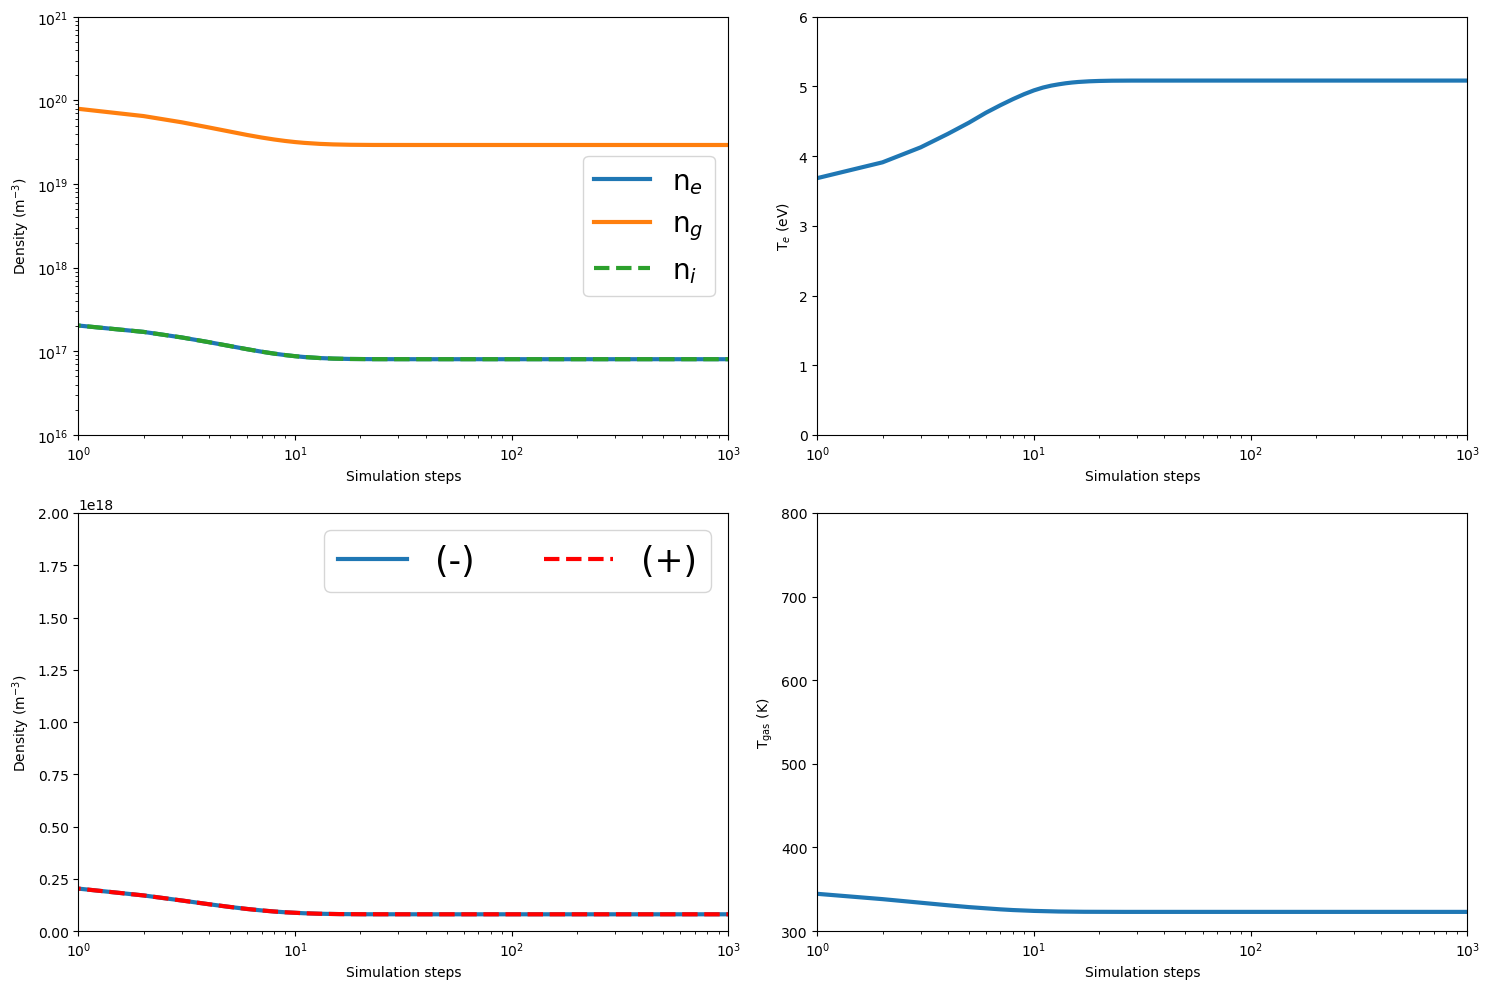

In [9]:
main_element = [a for a in chem.R.keys()][0] #Xenon


fig, ax = plt.subplots(2,2,figsize=(15,10))

ax[0,0].plot(n_e, label=r'n$_e$',linewidth=3)
ax[0,0].plot(n_g, label='n$_g$',linewidth=3)
ax[0,0].plot(n_i, label=r'n$_i$',linestyle='dashed',linewidth=3)
ax[0,0].legend(loc='best',ncol=1,fontsize=20)
ax[0,0].set_xscale('log')
ax[0,0].set_yscale('log')
ax[0,0].set_xlabel('Simulation steps')
ax[0,0].set_ylabel(r'Density (m$^{-3}$)')
ax[0,0].set_ylim(1e16,1e21)


ax[0,1].plot(T_e,linewidth=3)
ax[0,1].set_xscale('log')
ax[0,1].set_xlabel('Simulation steps')
ax[0,1].set_ylabel(r'T$_e$ (eV)')
ax[0,1].set_ylim(0,6)

ax[1,0].plot(n_e, label='(-)',linewidth=3)
ax[1,0].plot(n_i, label='(+)',linestyle='dashed',linewidth=3,color='r')
ax[1,0].legend(loc='best',ncol=2,fontsize=25)
ax[1,0].set_xscale('log')
ax[1,0].set_xlabel('Simulation steps')
ax[1,0].set_ylabel(r'Density (m$^{-3}$)')
ax[1,0].set_ylim(0,2e18)


ax[1,1].plot(T_g*e/k,linewidth=3)
ax[1,1].set_xscale('log')
ax[1,1].set_xlabel('Simulation steps')
ax[1,1].set_ylabel(r'T$_{\rm{gas}}$ (K)')
ax[1,1].set_ylim(300,800)

ax[0,0].set_xlim(1,1000)
ax[1,0].set_xlim(1,1000)
ax[0,1].set_xlim(1,1000)
ax[1,1].set_xlim(1,1000)

plt.tight_layout()

After a tens of simulation steps, the values converge.

# 3.1) Study as a function of the coil current or the RF power

In [10]:
gen_diff_all_gases('input_{}.txt'.format(gas))

my_objects = generate_all_objects('input_{}.txt'.format(gas))

thruster = my_objects[0]
params = my_objects[1]
chem = my_objects[2]
main_element = [a for a in chem.R.keys()][0]

init = chem.init_vector


########################################################################
### INPUT found in the input file that can be directly modified here ###
######################################################################## 
I_COIL = np.arange(1.5,25,0.5)          # List of input current (A)

mass_flow_range = [29]                # List of input mass flow rate (sccm)

thruster.N = 6                        # Number of coil turns
thruster.R = 0.06                     # thruster radius (m)
thruster.L = 0.1                      # Thruster length (m)
thruster.l_coil = thruster.L          # Coil length (m)
thruster.r_coil = 0.065               # Coil radius (m)
thruster.beta_ions = 0.7              # Grids transparency for ions
thruster.beta_neutrals = 0.3          # Grids transparency for neutrals
thruster.Vgrids = 1000                # Grids acceleration voltage (V)
thruster.grid_dist = 1.e-3            # Distance between grids (m)

##########################################################

results = [] 

for mfr in tqdm(mass_flow_range):      # Loop on the mass flow rate (optional here)
    
    params.Q0 = sccm_to_persecond(mfr) # Convert sccm unit to s-1 (neutral flow rate)
    
    for I in I_COIL:                   # Loop on the coil current 
        
        params.I_coil = I
    
        res_tmp = solve_all_gases(thruster, params, chem, init, temporal=False)  # Numerical resolution
        init = chem.init_vector                                                  # Use the latest converged solution as next input
        results.append([mfr, I, *res_tmp.y[:,-1]])                               # Append the results in the list results
        
# Convert the results into a DataFrame (Table)        
df_results = pd.DataFrame(results, columns=['mfc', 'I_coil', 'n_e', 'n_g', 'n_i', 'Te', 'Tg'])  

# Visualize the table results
df_results.head()


generated_diff_all_gases.py est ok!


100%|██████████| 1/1 [00:05<00:00,  5.31s/it]


,mfc,I_coil,n_e,n_g,n_i,Te,Tg
0,29,1.5,6.970598e+16,6.678189e+19,6.970598e+16,2.364490,0.027049
1,29,2.0,1.103029e+17,6.521788e+19,1.103029e+17,2.377718,0.027723
2,29,2.5,1.527166e+17,6.363636e+19,1.527166e+17,2.391886,0.028410
3,29,3.0,1.965126e+17,6.205203e+19,1.965126e+17,2.406947,0.029106
4,29,3.5,2.412853e+17,6.047655e+19,2.412853e+17,2.422858,0.029802


## The table of results is filled with various physical quantities

In [11]:
R_ind_Istar_included=np.vectorize(R_ind_Istar_included)
R_ind_noble_gas=np.vectorize(R_ind_noble_gas)
R_ind=np.vectorize(R_ind)

## Pressure : ideal gas law
df_results['total_pressure'] = (df_results.n_g*e*df_results.Tg+ df_results.n_e*e*df_results.Te+df_results.n_i*k**0.1*e)
df_results['neutral_pressure'] = (df_results.n_g*e*df_results.Tg )

## Electrical circuit
df_results['R_ind'] = R_ind_noble_gas(df_results.n_e,df_results.n_g,df_results.Te,df_results.Tg,thruster.r_coil,thruster.l_coil,thruster.w,thruster.N,chem.R,main_element)
df_results['Pd']   =  0.5*df_results['I_coil']**2*df_results['R_ind']
df_results['P_RF'] = df_results['Pd'] + 0.5*df_results['I_coil']**2*4#R_coil(df_results['I_coil'])
## Current
df_results['J_i'] = J_i(thruster.L,thruster.R,df_results.n_g,df_results.n_e,0,df_results.Te,df_results.Tg,df_results.n_i,main_element)

### Thrust
df_results['Thrust_i'] = thrust_ions(thruster.L,thruster.R,df_results.n_g,df_results.n_e,0,df_results.Te,df_results.Tg,df_results.n_i,main_element)
df_results['Thrust_g'] = thrust_neutrals(df_results.n_g,df_results.Tg,main_element)
df_results['Total_Thrust'] = df_results['Thrust_i']+df_results['Thrust_g']

### Ion / Neutral Power
df_results['Ions_Power'] = IonThrustpower(thruster.L,thruster.R,df_results.n_g,df_results.n_e,0,df_results.Te,df_results.Tg,df_results.n_i,main_element)
df_results['Neutrals_Power'] = NeutralThrustpower(df_results.n_g,df_results.Tg,main_element)
df_results['Total_Power'] = df_results['P_RF'] + df_results['Neutrals_Power'] + df_results['Ions_Power']

### Efficiencies
df_results['gamma'] = (df_results['Ions_Power']+df_results['Neutrals_Power'])/(df_results['Ions_Power']+df_results['Neutrals_Power']+df_results['P_RF'])
df_results['zeta'] = df_results['R_ind'] / (df_results['R_ind']+R_coil(df_results['I_coil']))
df_results['eta_mass'] = (df_results['Ions_Power']/(e * thruster.Vgrids))/(df_results['mfc']*4.47796e17)
df_results['eta_thruster'] = df_results['eta_mass']*df_results['gamma']

for a in chem.R.keys():
        for b in chem.R[a].keys():
            for d in chem.R[a][b].keys():
                df_results[d]=chem.R[a][b][d].K(df_results['Te'])
                df_results['E_'+d]=chem.R[a][b][d].energy_loss(df_results['Te'])
                
df_results['hL'] = hl(thruster.L,df_results.n_g,df_results.n_e,0,df_results.Te,df_results.Tg,params.sigma)
df_results['hR'] = hr(thruster.R,df_results.n_g,df_results.n_e,0,df_results.Te,df_results.Tg,params.sigma)
df_results['A_eff_loss'] = df_results['hL'] * 2 * np.pi * thruster.R**2 + 2 * np.pi * thruster.R * thruster.L * df_results['hR']
df_results['A_eff_wall'] = np.pi * thruster.R**2 * (2-thruster.beta_ions)*df_results['hL']+ 2 * np.pi * thruster.R * thruster.L * df_results['hR']
df_results['A_eff_open'] = np.pi * thruster.R**2 * thruster.beta_ions*df_results['hL']
df_results['A_n'] = np.pi * thruster.R**2 * (2-thruster.beta_neutrals) + 2 * np.pi * thruster.R * thruster.L

if main_element == 'Xe':
    df_results['E_cost'] = df_results['E_IONIZATION']+df_results['E_EXCITATION1']*df_results['EXCITATION1']/df_results['IONIZATION'] + df_results['E_EXCITATION2']*df_results['EXCITATION2']/df_results['IONIZATION'] + df_results['E_EXCITATION3']*df_results['EXCITATION3']/df_results['IONIZATION'] + df_results['E_EXCITATION4']*df_results['EXCITATION4']/df_results['IONIZATION']+3*m_e/m_Xe*df_results['ELASTIC']*e*df_results['Te']/df_results['IONIZATION']
if main_element == 'Ar':
    df_results['E_cost'] = df_results['E_IONIZATION']+df_results['E_EXCITATION1']*df_results['EXCITATION1']/df_results['IONIZATION'] + df_results['E_EXCITATION2']*df_results['EXCITATION2']/df_results['IONIZATION'] + df_results['E_EXCITATION3']*df_results['EXCITATION3']/df_results['IONIZATION'] +3*m_e/m_Ar*df_results['ELASTIC']*e*df_results['Te']/df_results['IONIZATION']
if main_element == 'Kr':
    df_results['E_cost'] = df_results['E_IONIZATION']+df_results['E_EXCITATION1']*df_results['EXCITATION1']/df_results['IONIZATION'] + df_results['E_EXCITATION2']*df_results['EXCITATION2']/df_results['IONIZATION'] + df_results['E_EXCITATION3']*df_results['EXCITATION3']/df_results['IONIZATION'] + df_results['E_EXCITATION4']*df_results['EXCITATION4']/df_results['IONIZATION']+3*m_e/m_Kr*df_results['ELASTIC']*e*df_results['Te']/df_results['IONIZATION']
    


## Densities vs RF Power

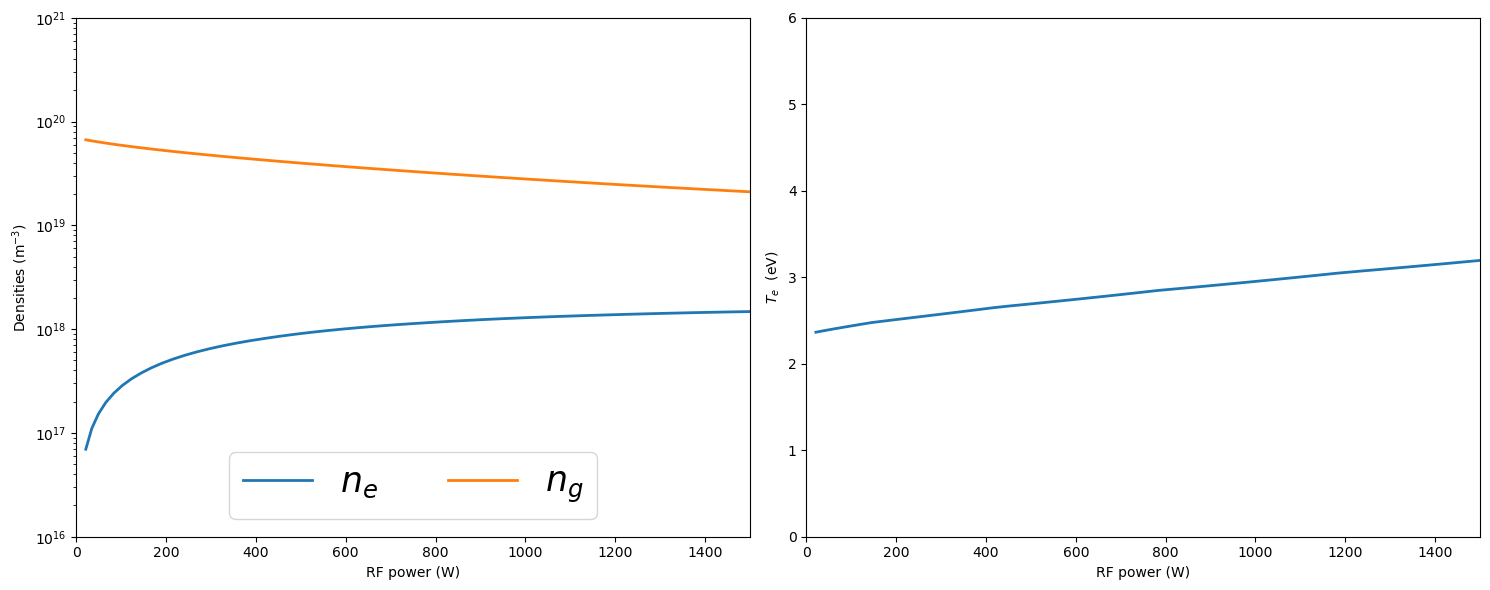

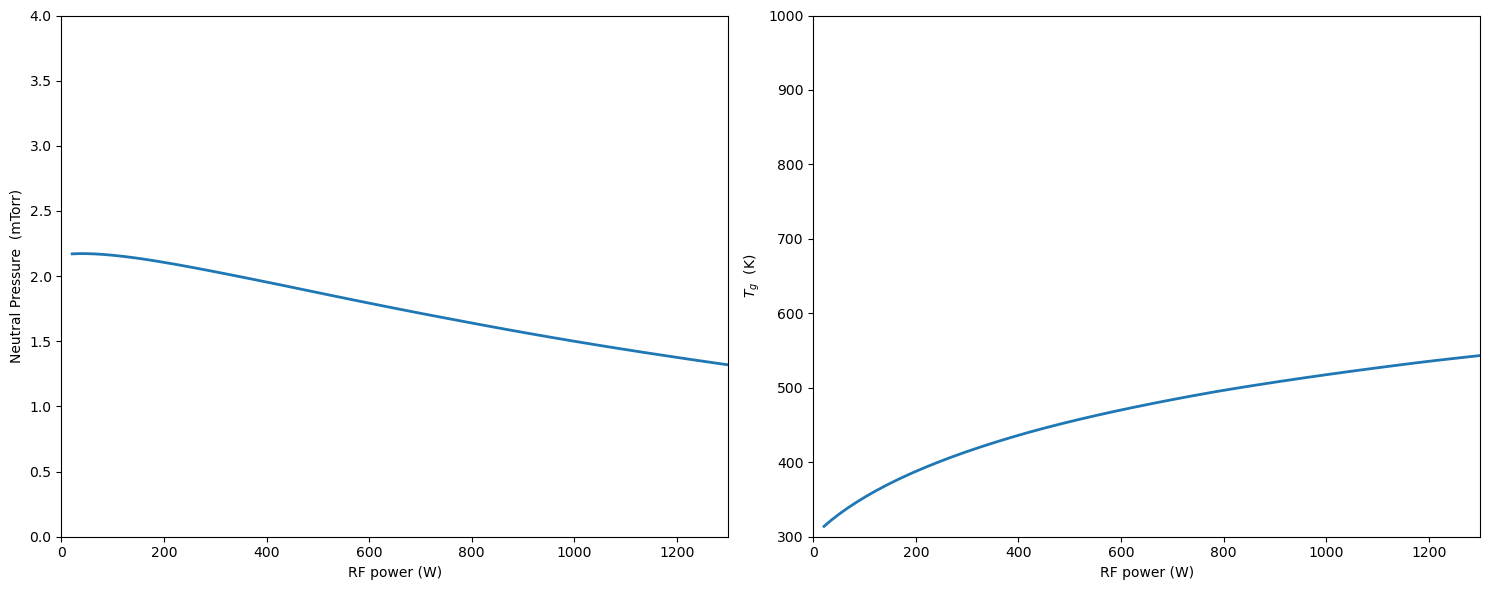

In [12]:
fig, ax = plt.subplots(1,2,figsize=(15,6))

ax[0].plot(df_results.P_RF, df_results.n_e, linewidth=2, label='$n_e$')
ax[0].plot(df_results.P_RF, df_results.n_g, linewidth=2, label='$n_g$')


ax[0].set_yscale('log')
ax[0].set_xlabel(r'RF power (W)')
ax[0].set_ylabel(r'Densities (m$^{-3}$)')
ax[0].set_xlim([0, 1.5e3])
ax[0].set_ylim([1e16, 1e21])
ax[0].legend(loc='lower center',ncol=2,fontsize=25)
plt.tight_layout()


ax[1].plot(df_results.P_RF, df_results.Te, linewidth=2)


ax[1].set_xlabel(r'RF power (W)')
ax[1].set_ylabel(r'$T_e$  (eV)')
ax[1].set_xlim([0, 1.5e3])
ax[1].set_ylim([0,6])
plt.tight_layout()

fig, ax = plt.subplots(1,2,figsize=(15,6))

ax[0].plot(df_results.P_RF, df_results.neutral_pressure*7.5, linewidth=2)

ax[0].set_xlabel(r'RF power (W)')
ax[0].set_ylabel(r'Neutral Pressure  (mTorr)')
ax[0].set_xlim([0, 1.3e3])
ax[0].set_ylim([0,4])
plt.tight_layout()


ax[1].plot(df_results.P_RF, df_results.Tg* e/k, linewidth=2)

ax[1].set_xlabel(r'RF power (W)')
ax[1].set_ylabel(r'$T_g$  (K)')
ax[1].set_xlim([0, 1.3e3])
ax[1].set_ylim([300,1000])

plt.tight_layout()

### 2) Let us now consider a gas flow rate of $Q_0 = 29$ sccm and a grid transparency for neutrals of $\beta_g = 0.3$. Use the numerical code to plot $n_g$, $n_e$, $T_g$, $T_e$ and $p$ (the neutral gas pressure) as a function of the coil current, varying $I_{coil}$ from 1.5 to 25 Amps.


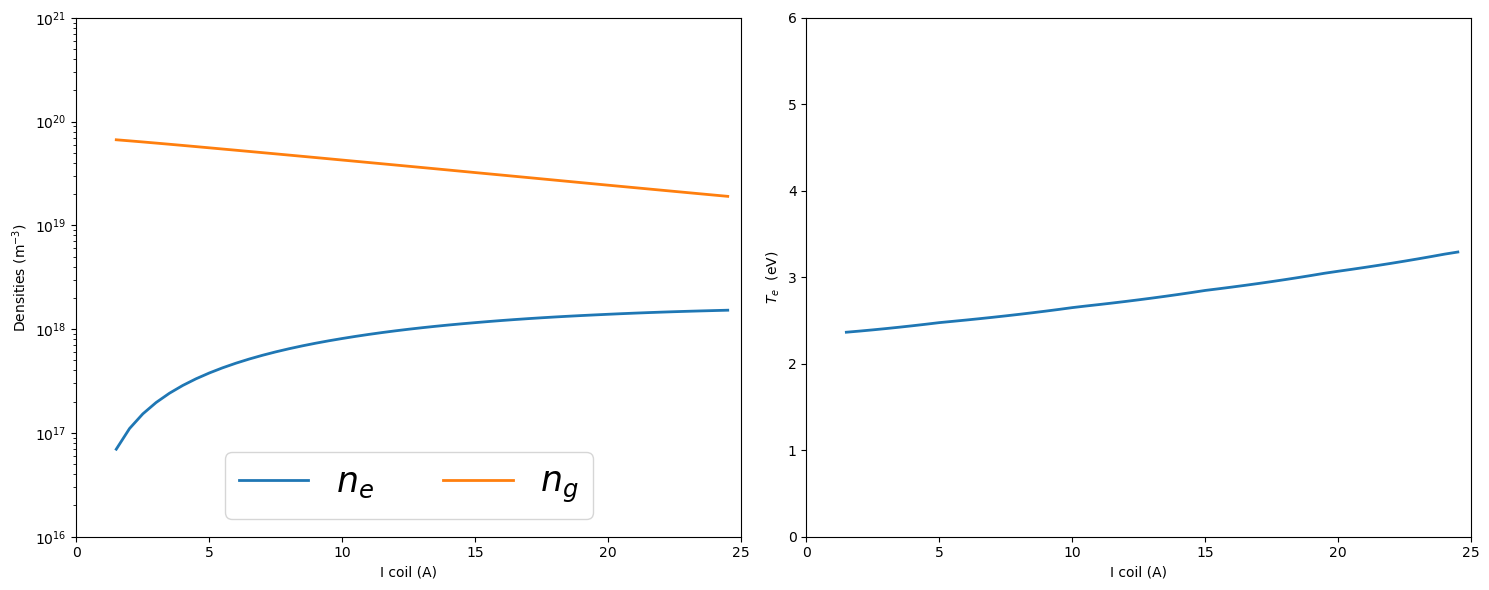

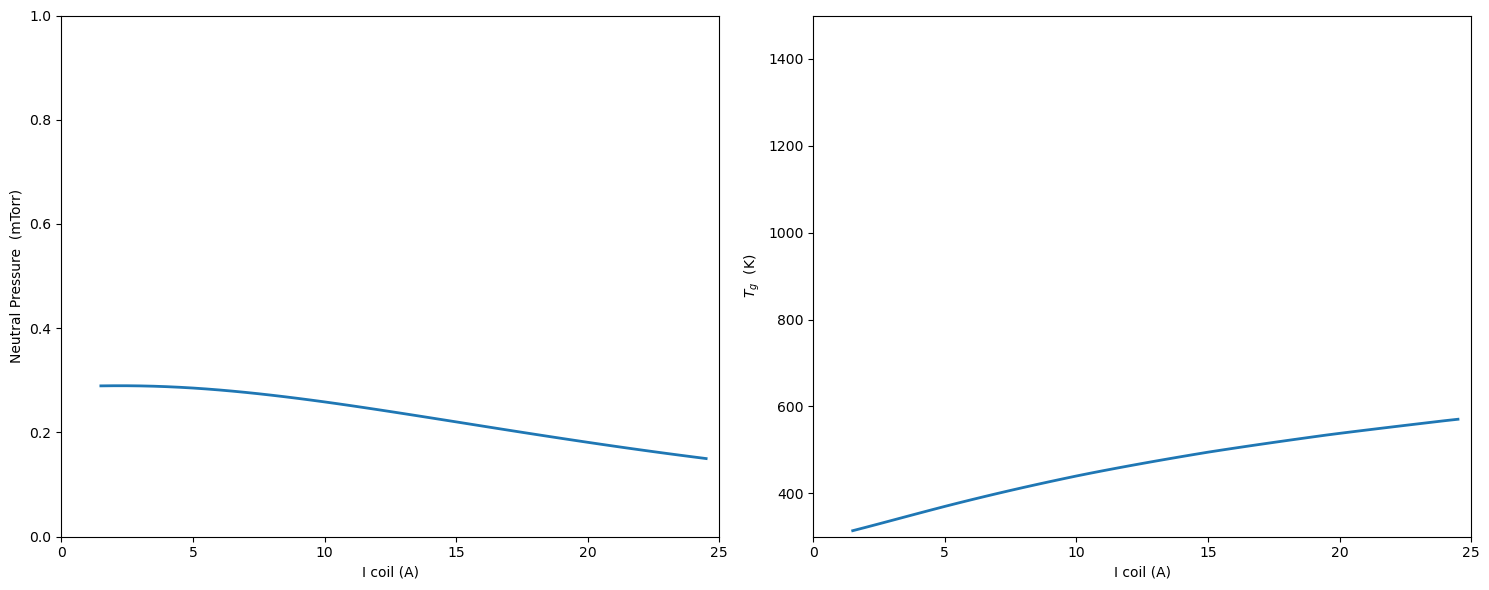

In [13]:
fig, ax = plt.subplots(1,2,figsize=(15,6))

ax[0].plot(df_results.I_coil, df_results.n_e, linewidth=2, label='$n_e$')
ax[0].plot(df_results['I_coil'], df_results.n_g, linewidth=2, label='$n_g$')


ax[0].set_yscale('log')
ax[0].set_xlabel(r'I coil (A)')
ax[0].set_ylabel(r'Densities (m$^{-3}$)')
ax[0].set_xlim([0, 25])
ax[0].set_ylim([1e16, 1e21])
ax[0].legend(loc='lower center',ncol=2,fontsize=25)
plt.tight_layout()



ax[1].plot(df_results['I_coil'], df_results.Te, linewidth=2)


ax[1].set_xlabel(r'I coil (A)')
ax[1].set_ylabel(r'$T_e$  (eV)')
ax[1].set_xlim([0, 25])
ax[1].set_ylim([0,6])
plt.tight_layout()

fig, ax = plt.subplots(1,2,figsize=(15,6))

ax[0].plot(df_results['I_coil'], df_results.neutral_pressure, linewidth=2)

ax[0].set_xlabel(r'I coil (A)')
ax[0].set_ylabel(r'Neutral Pressure  (mTorr)')
ax[0].set_xlim([0, 25])
ax[0].set_ylim([0,1])
plt.tight_layout()


ax[1].plot(df_results['I_coil'], df_results.Tg* e/k, linewidth=2)

ax[1].set_xlabel(r'I coil (A)')
ax[1].set_ylabel(r'$T_g$  (K)')
ax[1].set_xlim([0, 25])
ax[1].set_ylim([300,1500])

plt.tight_layout()

### 3) Compare on dedicated figures the above numerical solution (that includes neutral dynamics) to the analytical model where the neutral dynamics was not included, choosing $T_{g0} = 400$ K, $n_{g0}$, $n_e$, $T_e$ and $p_0$ calculated from simplified theory. For this calculation use:

\begin{align*}
u_B &= 3000 \rm{m/s}\\
h_R &= h_L = 0.5\\
E_{iz} &= 12.1 \rm{eV}\\
K_{iz0}\ &=\ 10^{-13}\ \rm{m}^3/\rm{s}\\
K_{el}\ &=\ 2 \times 10^{-13}\ \rm{m}^3/\rm{s}\\
\nu_m \ &=\ n_{g0}K_{el}
\end{align*}


### Comment on the discrepancies (in particular recall that in the analytical model the plasma resistance was approximated in the high electron density regime)


On prend $\epsilon_T = 50\text{eV}$ (taux d'ionisation)

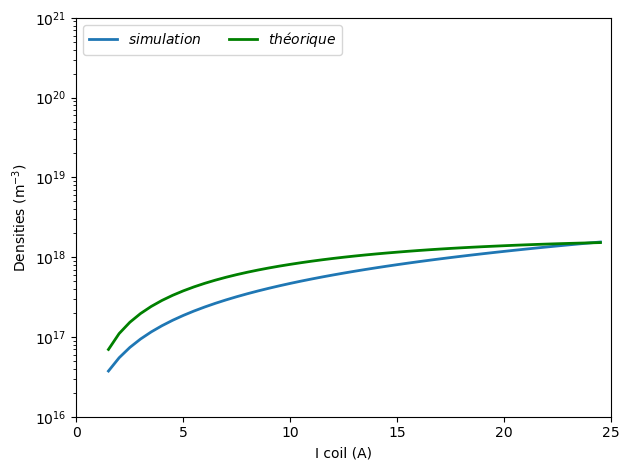

In [14]:
Q0 = sccm_to_persecond(29) #On convertit le débit dans la bonne unité
beta_g = 0.3
K_el = 2*1e-13
uB=3*1e+3
h_R = 1/2
h_L = 1/2
T_g = 400
epsilon_T = 50
E_iz = 12.1*e
Kiz_0 = 1e-13
A_open_g = beta_g*np.pi*0.065**2
v_g = np.sqrt(8*T_g*k/(np.pi*m_Xe))
n_g0 = 4*Q0/(v_g*A_open_g)
nu_m = K_el*n_g0
n_e = (np.pi*thruster.R*thruster.N**2*nu_m*np.sqrt(m_e/epsilon_0)/(4*uB*(h_L*np.pi*thruster.R**2 + h_R*np.pi*thruster.R*thruster.L)*e*epsilon_T*e*thruster.L*c))**(2/3)*df_results['I_coil']**(4/3)
T_e = -E_iz/k*(np.log(uB*2*((thruster.L)**(-1) + (thruster.R)**(-1))/(n_g0*Kiz_0)))**(-1)
p_0 = n_g0*k*T_g


plt.plot(df_results.I_coil, n_e, linewidth=2, label='$simulation$') #Experimental
plt.plot(df_results.I_coil, df_results.n_e, linewidth=2, label='$théorique$', color = 'g') #Théorie
plt.yscale('log')
plt.xlabel(r'I coil (A)')
plt.ylabel(r'Densities (m$^{-3}$)')
plt.xlim([0, 25])
plt.ylim([1e16, 1e21])
plt.legend(loc=2,ncol=2,fontsize=10)
plt.tight_layout()

### 4) Use the numerical model to plot the ion current density $J_i$ as a function of the RF power. Identify the Child-Langmuir limit and deduce the maximum RF power at which the thruster should operate. At this limit, evaluate the thrust.

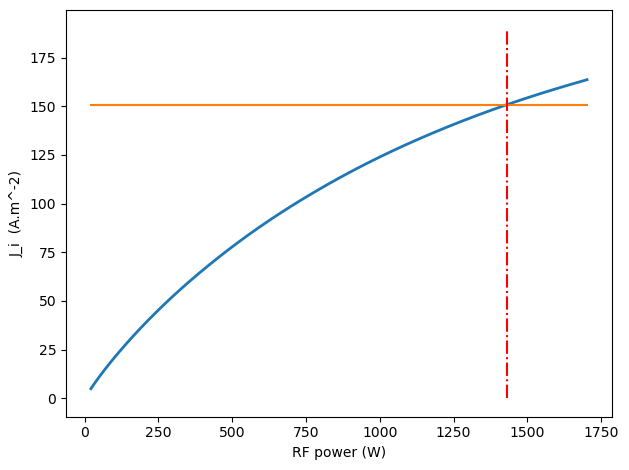

In [15]:
plt.plot(df_results.P_RF, df_results.J_i, linewidth=2)
J_langmuir = (4/9*epsilon_0*np.sqrt(2*1.6*10**(-19)/m_Xe)*1000**(3/2)/1.e-6)
plt.plot(df_results.P_RF, [J_langmuir for i in range(len(df_results.P_RF))])
plt.xlabel(r'RF power (W)')                        
plt.ylabel(r'J_i  (A.m^-2)')
plt.plot([1430 for i in range(20)], [10*i for i in range(20)], linestyle = 'dashdot', color = 'red')
plt.tight_layout()

On évalue alors le thurst avec la formule du cours. On trouve :

In [16]:
T = 8/9*epsilon_0*(thruster.Vgrids/thruster.grid_dist)**2*A_open_g
print(T)

0.03133964322844835


### 5) Use the numerical model to plot the thrust-to-power ratio as a function of the RF power and compare it to the theoretical formula given in the lecture. Discuss the discrepancy between the numerical solution and the theory.

Text(0, 0.5, 'Thrust Power efficiency (N/W)')

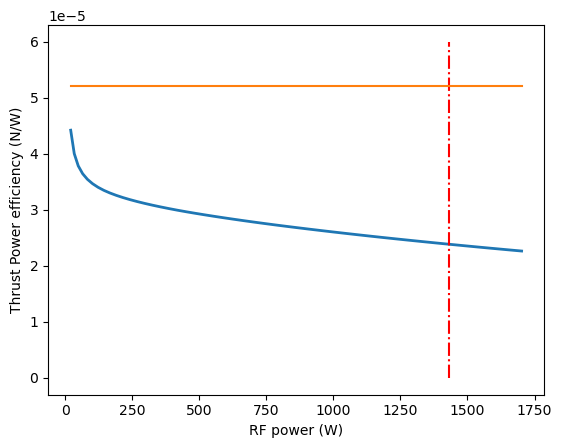

In [17]:
Thrust_to_Power = df_results['Total_Thrust']/(df_results['Total_Power'])
plt.plot(df_results.P_RF,Thrust_to_Power,linewidth = 2)
plt.plot([1430 for i in range(13)], [i/2e+5 for i in range(13)], linestyle = 'dashdot', color = 'red')
plt.plot(df_results.P_RF, [np.sqrt(2*m_Xe/(e*thruster.Vgrids)) for i in range(len(df_results.P_RF))])
plt.xlabel(r'RF power (W)')
plt.ylabel(r'Thrust Power efficiency (N/W)')

### 6) Use the numerical model to plot the inductive power transfer efficiency, defined 
as $$\zeta = \frac{R_{ind}}{R_{ind} + R_{coil}}$$ and compare it to the theoretical formula obtained using the simplified theory. For this calculation use $R_{coil}=2\ \Omega$ and use the electron and gas densities calculated from the coil (not the approximated formulas).

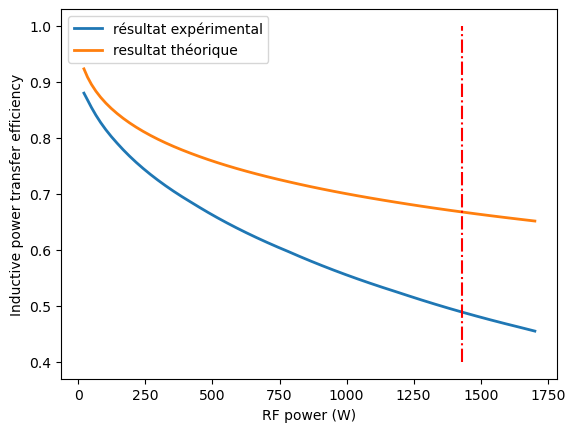

In [18]:
Xsi = df_results['R_ind']/(df_results['R_ind'] + [2 for i in range(len(df_results.R_ind))])
plt.plot(df_results.P_RF,Xsi,linewidth = 2, label = 'résultat expérimental')

w_pe = np.sqrt(n_e*e**2/(m_e*epsilon_0))
sigma_m = n_e*e**2/(m_e*nu_m)
delta = c/w_pe
R_ind = thruster.N**2*np.pi*thruster.R/(thruster.L*delta*sigma_m)

Xsi_theo = R_ind/(R_ind + [2 for i in range(len(R_ind))])
plt.plot(df_results.P_RF,Xsi_theo,linewidth = 2, label = 'resultat théorique')

plt.plot([1430 for i in range(7)], [i/10 for i in range(4,11)], linestyle = 'dashdot', color = 'red')
plt.legend()
plt.xlabel(r'RF power (W)')
plt.ylabel(r'Inductive power transfer efficiency')
plt.show()

# 3.2) Study as a function of the mass flow rate

In [35]:
gen_diff_all_gases('input_{}.txt'.format(gas))

my_objects = generate_all_objects('input_{}.txt'.format(gas))

thruster = my_objects[0]
params = my_objects[1]
chem = my_objects[2]
main_element = [a for a in chem.R.keys()][0]

init = chem.init_vector


########################################################################
### INPUT found in the input file that can be directly modified here ###
######################################################################## 

#I_COIL = np.arange(10,80,2)          # List of input current (A)

mass_flow_range = np.arange(200,30,-10) # List of input mass flow rate (sccm)

thruster.N = 6                        # Number of coil turns
thruster.R = 0.06                     # thruster radius (m)
thruster.L = 0.03                     # Thruster length (m)
thruster.l_coil = thruster.L          # Coil length (m)
thruster.r_coil = 0.065               # Coil radius (m)
thruster.beta_ions = 0.7              # Grids transparency for ions
thruster.beta_neutrals = 0.3          # Grids transparency for neutrals
thruster.Vgrids = 1000                # Grids acceleraton voltage (V)
thruster.grid_dist = 1.e-3            # Distance between grids (m)

##########################################################
JCL_Xe=Jcl(m_Xe,thruster.Vgrids,thruster.grid_dist)
JCL_Ar=Jcl(m_Ar,thruster.Vgrids,thruster.grid_dist)
JCL_Kr=Jcl(m_Kr,thruster.Vgrids,thruster.grid_dist)


results = [] 

for mfr in tqdm(mass_flow_range):      # Loop on the mass flow rate
    params.Q0 = sccm_to_persecond(mfr) # Convert sccm unit to s-1 (neutral flow rate)

    J_ions=0
    I=10
    delta_I=0.5
    while J_ions < JCL_Xe:             # Calculate until the Child-Langmuir current is reached
        print('Ion Current=%.2f A/m2'%J_ions)
        params.I_coil = I              
        res_tmp = solve_all_gases(thruster, params, chem, init, temporal=False)  # Numerical resolution
        init = chem.init_vector                                                  # Use the latest converged solution as next input
        J_ions=J_i(thruster.L,thruster.R,res_tmp.y[:,-1][1],res_tmp.y[:,-1][0],0,res_tmp.y[:,-1][3],res_tmp.y[:,-1][4],res_tmp.y[:,-1][2],main_element)

        I+=delta_I
    results.append([mfr, I, *res_tmp.y[:,-1]])
        
# Convert the results into a DataFrame (Table) 

df_results = pd.DataFrame(results, columns=['mfc', 'I_coil', 'n_e', 'n_g', 'n_i', 'Te', 'Tg'])  

# Visualize the table results
df_results.head()
#On sauve le tableau avec pd.csv
#et on relance avec l'argon


generated_diff_all_gases.py est ok!


  0%|          | 0/17 [00:00<?, ?it/s]

Ion Current=0.00 A/m2


 12%|█▏        | 2/17 [00:00<00:01, 10.81it/s]

Ion Current=0.00 A/m2
Ion Current=0.00 A/m2
Ion Current=0.00 A/m2


 24%|██▎       | 4/17 [00:00<00:01, 10.73it/s]

Ion Current=0.00 A/m2
Ion Current=0.00 A/m2


 35%|███▌      | 6/17 [00:00<00:01, 10.81it/s]

Ion Current=0.00 A/m2


 47%|████▋     | 8/17 [00:00<00:00, 11.02it/s]

Ion Current=0.00 A/m2
Ion Current=0.00 A/m2
Ion Current=0.00 A/m2


 59%|█████▉    | 10/17 [00:00<00:00, 10.87it/s]

Ion Current=0.00 A/m2
Ion Current=0.00 A/m2


 82%|████████▏ | 14/17 [00:01<00:00, 10.76it/s]

Ion Current=0.00 A/m2
Ion Current=0.00 A/m2
Ion Current=0.00 A/m2


100%|██████████| 17/17 [00:01<00:00, 10.47it/s]

Ion Current=0.00 A/m2
Ion Current=0.00 A/m2


,mfc,I_coil,n_e,n_g,n_i,Te,Tg
0,200,10.5,2.635808e+18,1.473774e+20,2.635808e+18,3.798190,0.045292
1,190,10.5,2.526239e+18,1.395863e+20,2.526239e+18,3.855808,0.044625
2,180,10.5,2.413860e+18,1.317106e+20,2.413860e+18,3.922524,0.043979
3,170,10.5,2.298528e+18,1.237497e+20,2.298528e+18,4.000555,0.043358
4,160,10.5,2.181689e+18,1.157997e+20,2.181689e+18,4.081150,0.042727


In [37]:
R_ind_Istar_included=np.vectorize(R_ind_Istar_included)
R_ind_noble_gas=np.vectorize(R_ind_noble_gas)
R_ind=np.vectorize(R_ind)

## Pressure
df_results['total_pressure'] = (df_results.n_g*e*df_results.Tg+ df_results.n_e*e*df_results.Te+df_results.n_i*k**0.1*e)
df_results['neutral_pressure'] = (df_results.n_g*e*df_results.Tg )

## Electrical circuit
df_results['R_ind'] = R_ind_noble_gas(df_results.n_e,df_results.n_g,df_results.Te,df_results.Tg,thruster.r_coil,thruster.l_coil,thruster.w,thruster.N,chem.R,main_element)
df_results['Pd']   =  0.5*df_results['I_coil']**2*df_results['R_ind']
df_results['P_RF'] = df_results['Pd'] + 0.5*df_results['I_coil']**2*4#R_coil(df_results['I_coil'])
## Current
df_results['J_i'] = J_i(thruster.L,thruster.R,df_results.n_g,df_results.n_e,0,df_results.Te,df_results.Tg,df_results.n_i,main_element)
#
### Thrust
df_results['Thrust_i'] = thrust_ions(thruster.L,thruster.R,df_results.n_g,df_results.n_e,0,df_results.Te,df_results.Tg,df_results.n_i,main_element)
df_results['Thrust_g'] = thrust_neutrals(df_results.n_g,df_results.Tg,main_element)
df_results['Total_Thrust'] = df_results['Thrust_i']+df_results['Thrust_g']
#
### Ion / Neutral Power
df_results['Ions_Power'] = IonThrustpower(thruster.L,thruster.R,df_results.n_g,df_results.n_e,0,df_results.Te,df_results.Tg,df_results.n_i,main_element)
df_results['Neutrals_Power'] = NeutralThrustpower(df_results.n_g,df_results.Tg,main_element)
df_results['Total_Power'] = df_results['P_RF'] + df_results['Neutrals_Power'] + df_results['Ions_Power']
#
### Efficiencies
df_results['gamma'] = (df_results['Ions_Power']+df_results['Neutrals_Power'])/(df_results['Ions_Power']+df_results['Neutrals_Power']+df_results['P_RF'])
df_results['zeta'] = df_results['R_ind'] / (df_results['R_ind']+R_coil(df_results['I_coil']))
df_results['eta_mass'] = (df_results['Ions_Power']/(e * thruster.Vgrids))/(df_results['mfc']*4.47796e17)
df_results['eta_thruster'] = df_results['eta_mass']*df_results['gamma']

for a in chem.R.keys():
        for b in chem.R[a].keys():
            for d in chem.R[a][b].keys():
                df_results[d]=chem.R[a][b][d].K(df_results['Te'])
                df_results['E_'+d]=chem.R[a][b][d].energy_loss(df_results['Te'])
                
df_results['hL'] = hl(thruster.L,df_results.n_g,df_results.n_e,0,df_results.Te,df_results.Tg,params.sigma)
df_results['hR'] = hr(thruster.R,df_results.n_g,df_results.n_e,0,df_results.Te,df_results.Tg,params.sigma)
df_results['A_eff_loss'] = df_results['hL'] * 2 * np.pi * thruster.R**2 + 2 * np.pi * thruster.R * thruster.L * df_results['hR']
df_results['A_eff_wall'] = np.pi * thruster.R**2 * (2-thruster.beta_ions)*df_results['hL']+ 2 * np.pi * thruster.R * thruster.L * df_results['hR']
df_results['A_eff_open'] = np.pi * thruster.R**2 * thruster.beta_ions*df_results['hL']
df_results['A_n'] = np.pi * thruster.R**2 * (2-thruster.beta_neutrals) + 2 * np.pi * thruster.R * thruster.L

if main_element == 'Xe':
    df_results['E_cost'] = df_results['E_IONIZATION']+df_results['E_EXCITATION1']*df_results['EXCITATION1']/df_results['IONIZATION'] + df_results['E_EXCITATION2']*df_results['EXCITATION2']/df_results['IONIZATION'] + df_results['E_EXCITATION3']*df_results['EXCITATION3']/df_results['IONIZATION'] + df_results['E_EXCITATION4']*df_results['EXCITATION4']/df_results['IONIZATION']+3*m_e/m_Xe*df_results['ELASTIC']*e*df_results['Te']/df_results['IONIZATION']

In [38]:
## Save the result into a csv file

if 'df_results' in locals():
    df_results.to_csv(f'./{gas}_L={thruster.L}.csv',index=False)
## To access and read the saved csv file:

df_results = pd.read_csv(f'./{gas}_L={thruster.L}.csv')
df_results.head()

,mfc,I_coil,n_e,n_g,n_i,Te,Tg,total_pressure,neutral_pressure,R_ind,...,EXCITATION2,E_EXCITATION2,EXCITATION3,E_EXCITATION3,hL,hR,A_eff_loss,A_eff_wall,A_eff_open,A_n
0,200,10.5,2.635808e+18,1.473774e+20,2.635808e+18,3.798190,0.045292,2.675631,1.069458,17.011624,...,4.558231e-16,13.0,1.649058e-16,14.0,0.373082,0.216242,0.010885,0.007931,0.002954,0.030536
1,190,10.5,2.526239e+18,1.395863e+20,2.526239e+18,3.855808,0.044625,2.560733,0.998008,16.680072,...,4.837390e-16,13.0,1.760738e-16,14.0,0.377689,0.220854,0.011041,0.008051,0.002990,0.030536
2,180,10.5,2.413860e+18,1.317106e+20,2.413860e+18,3.922524,0.043979,2.447078,0.928067,16.348757,...,5.160633e-16,13.0,1.890054e-16,14.0,0.382496,0.225774,0.011205,0.008177,0.003028,0.030536
3,170,10.5,2.298528e+18,1.237497e+20,2.298528e+18,4.000555,0.043358,2.334824,0.859654,16.019511,...,5.538692e-16,13.0,2.041299e-16,14.0,0.387515,0.231037,0.011378,0.008310,0.003068,0.030536
4,160,10.5,2.181689e+18,1.157997e+20,2.181689e+18,4.081150,0.042727,2.221068,0.792712,15.648511,...,5.956062e-16,13.0,2.211274e-16,14.0,0.392692,0.236598,0.011558,0.008449,0.003109,0.030536


### Visualize the currents reached

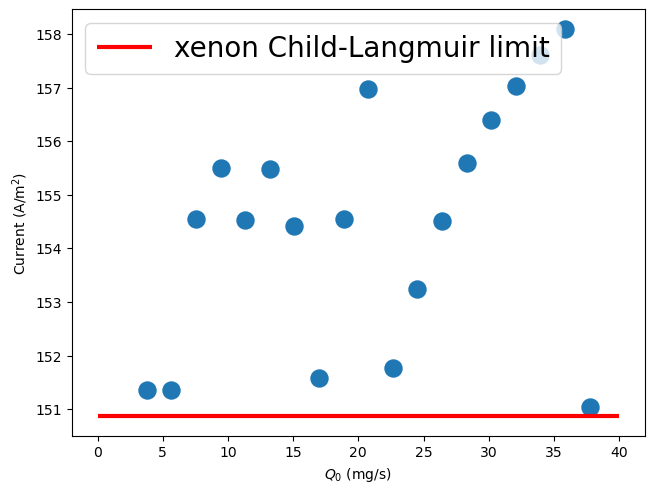

In [21]:
plt.scatter(df_results.mfc*0.18872,df_results.J_i,s=150)
plt.hlines(JCL_Xe,0,40,color='r',label=f'{gas} Child-Langmuir limit',linewidth=3)
# plt.ylim(0,200)
# plt.xlim(0,40)
plt.legend(fontsize=20)
plt.tight_layout()

plt.xlabel(r'$Q_0$ (mg/s)')
plt.ylabel(r'Current (A/m$^2$)')
plt.show()

### 1) Use the numerical model to plot the mass utilization efficiency $\eta$, electrical power efficiency $\gamma$, and the total thruster efficiency $\eta_{\rm{thruster}}=\eta \gamma$ as a function of $Q_m$. 

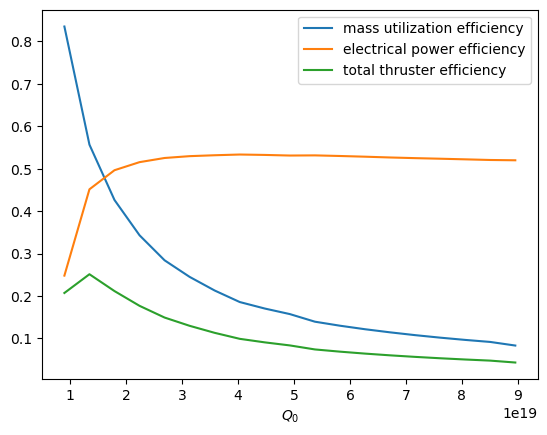

In [18]:
###################################################
mass_flow_range = np.arange(200,10,-10)
Q = [sccm_to_persecond(i) for i in mass_flow_range] 
df_xenon = pd.read_csv(f'{gas}_L=0.1.csv')
eta = df_xenon['eta_mass']
plt.plot(Q,eta, label = 'mass utilization efficiency')

plt.xlabel(r'$Q_0$')

###################################################
gamma = (df_xenon['Neutrals_Power'] + df_xenon['Ions_Power'])/df_xenon['Total_Power'] 
plt.plot(Q, gamma, label = 'electrical power efficiency')
###################################################

plt.plot(Q,eta*gamma, label='total thruster efficiency')
plt.legend()
plt.show()

### 2) Run the simulation code again for $L = 0.03$ m instead of $L = 0.1$ m and plot the total efficiency as a function of $Q_m$. Comment the result.

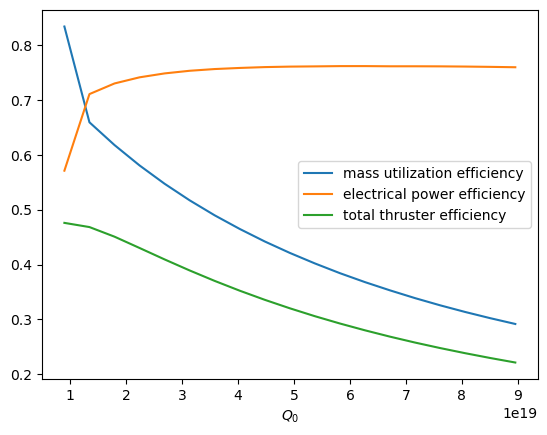

In [22]:
###################################################
mass_flow_range = np.arange(200,10,-10)
Q = [sccm_to_persecond(i) for i in mass_flow_range]  
df_xenonL3 = pd.read_csv(f'{gas}_L={thruster.L}.csv')
eta = df_xenonL3['eta_mass']
plt.plot(Q,eta, label = 'mass utilization efficiency')

plt.xlabel(r'$Q_0$')
###################################################
gamma = (df_xenonL3['Neutrals_Power'] + df_xenonL3['Ions_Power'])/df_xenonL3['Total_Power'] 
plt.plot(Q, gamma, label = 'electrical power efficiency')

###################################################

plt.plot(Q,eta*gamma, label='total thruster efficiency')
plt.legend()
plt.show()

### 3) Run the simulation code for  $L = 0.1$ and  $L = 0.03$ m for argon, krypton and xenon and identify the maximum efficiency for the three propellants. Plot the thrust-to-power ratio for the same conditions ($L = 0.1$ and  $L = 0.03$ m for argon, krypton and xenon).

To run the code with a different propellant, you have to 'Restart the kernel' and change the gas at the beginning. The minimal mass flow rate and minimal coil current have to be adjusted when changing the gas.

To compare the different propellants on the same graph, do not forget to save the table of results (df_results) by using df_results.to_csv('Name_of_saved_file.csv'). 


To access the saved table, simply use df=pd.read_csv('./Name_of_saved_file.csv').

Attention: The transition from sccm unit to mg/s is gas dependent !!!! 

### With Xenon 

Pour $L = 0.1$ m

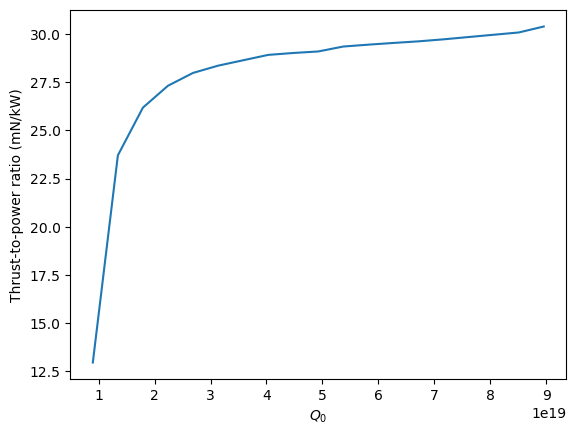

In [25]:
if gas=='xenon':
    mass_flow_range = np.arange(200,10,-10)
    Q = [sccm_to_persecond(i) for i in mass_flow_range]
    df_xenon = pd.read_csv(f'./{gas}_L=0.1.csv')
    plt.plot(Q,df_xenon['Total_Thrust']*1e3/(df_xenon['Total_Power']*1e-3))
    plt.ylabel('Thrust-to-power ratio (mN/kW)')
    plt.xlabel('$Q_0$')
    plt.show()

Pour $L = 0.03m$

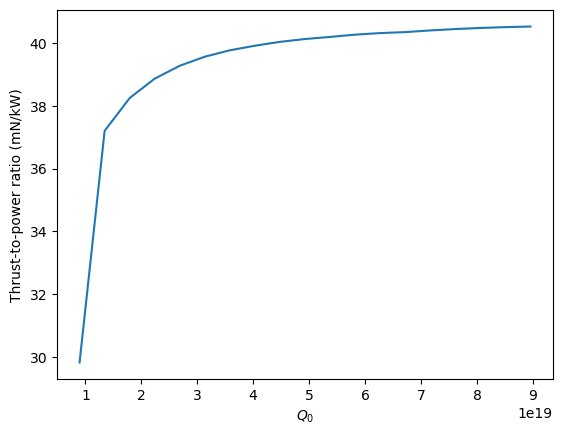

In [ ]:
if gas=='xenon':
    mass_flow_range = np.arange(200,10,-10)
    Q = [sccm_to_persecond(i) for i in mass_flow_range]
    df_xenon = pd.read_csv(f'./{gas}_L=0.03.csv')
    plt.plot(Q,df_xenon['Total_Thrust']*1e3/(df_xenon['Total_Power']*1e-3))
    plt.ylabel('Thrust-to-power ratio (mN/kW)')
    plt.xlabel('$Q_0$')
    plt.show()

### With krypton

$L = 0.1$ m

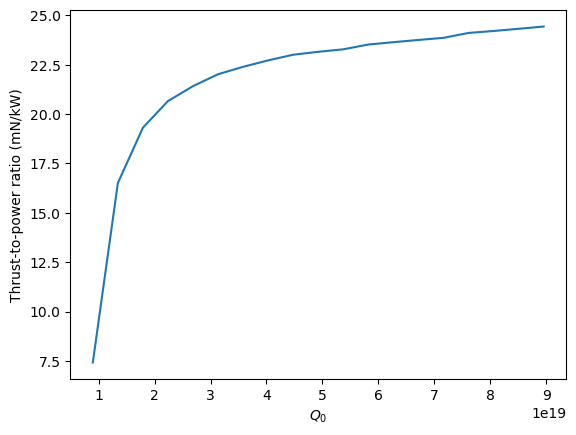

In [ ]:
if gas=='krypton':
    mass_flow_range = np.arange(200,10,-10)
    Q = [sccm_to_persecond(i) for i in mass_flow_range] 
    df_krypton = pd.read_csv(f'./{gas}_L=0.1.csv')
    plt.plot(Q,df_krypton['Total_Thrust']*1e3/(df_krypton['Total_Power']*1e-3))  

    plt.ylabel('Thrust-to-power ratio (mN/kW)')
    plt.xlabel('$Q_0$')
    plt.show()

$L = 0.03$ m

In [32]:
if gas=='krypton':
    mass_flow_range = np.arange(200,30,-10)
    Q = [sccm_to_persecond(i) for i in mass_flow_range]  
    df_krypton_L3 = pd.read_csv(f'./{gas}_L=0.03.csv')
    plt.plot(Q,df_krypton_L3['Total_Thrust']*1e3/(df_krypton_L3['Total_Power']*1e-3))  
    plt.ylabel('Thrust-to-power ratio (mN/kW)')
    plt.xlabel('$Q_0$')
    plt.show()

### With Argon

$L = 0.1$ m

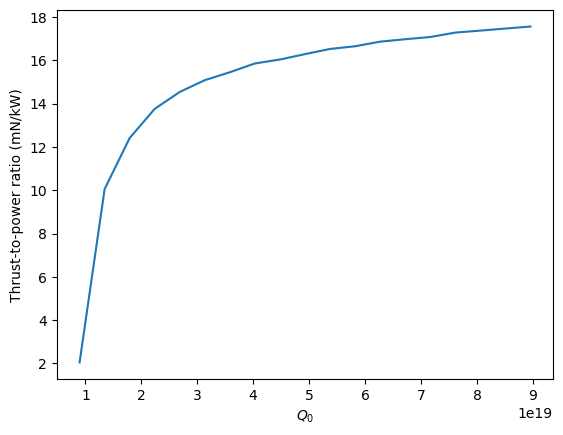

In [13]:
if gas=='argon':

    Q = [sccm_to_persecond(i) for i in mass_flow_range] 
    df_argon = pd.read_csv(f'./{gas}_L=0.1.csv')

    plt.plot(Q,df_argon['Total_Thrust']*1e3/(df_argon['Total_Power']*1e-3))  

    plt.ylabel('Thrust-to-power ratio (mN/kW)')
    plt.xlabel('$Q_0$')

$L = 0.03$ m

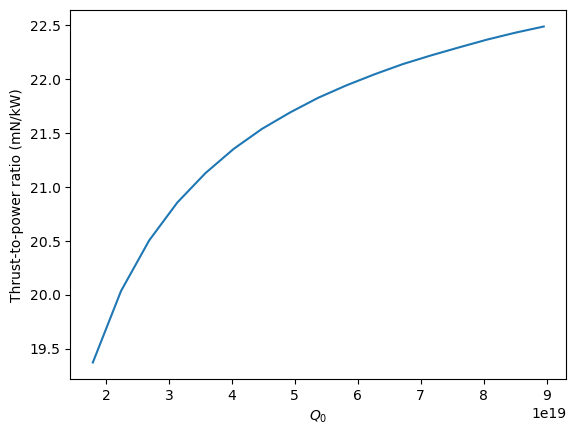

In [40]:
if gas=='argon':

    mass_flow_range = np.arange(200,30,-10)
    Q = [sccm_to_persecond(i) for i in mass_flow_range]
    df_krypton_L3 = pd.read_csv(f'./{gas}_L=0.03.csv')
    plt.plot(Q,df_krypton_L3['Total_Thrust']*1e3/(df_krypton_L3['Total_Power']*1e-3))  
    plt.ylabel('Thrust-to-power ratio (mN/kW)')
    plt.xlabel('$Q_0$')

### 4) Plot the thrust as a function of the mass flow rate for the three propellants. Comment the results.

### Xenon

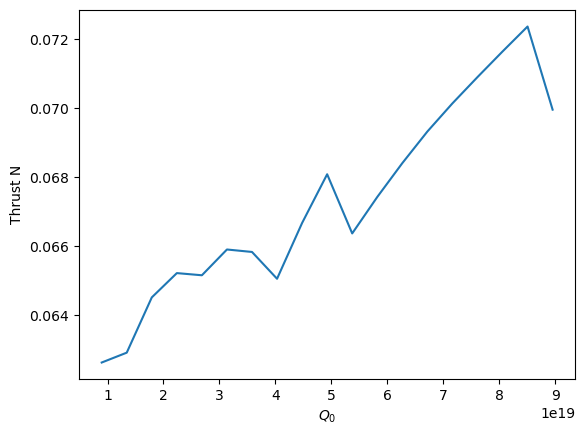

In [ ]:
mass_flow_range = np.arange(200,10,-10)
Q = [sccm_to_persecond(i) for i in mass_flow_range]
plt.plot(Q,df_xenon['Total_Thrust'])  
plt.ylabel('Thrust N')
plt.xlabel('$Q_0$')
plt.show()

### Krypton

Text(0.5, 0, '$Q_0$')

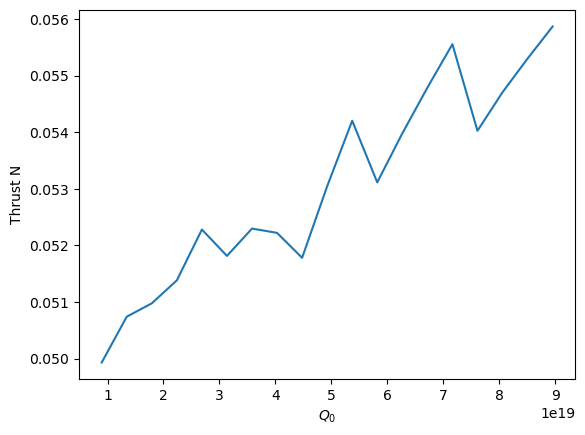

In [ ]:
mass_flow_range = np.arange(200,10,-10)
Q = [sccm_to_persecond(i) for i in mass_flow_range]
plt.plot(Q,df_krypton['Total_Thrust'])
plt.ylabel('Thrust N')
plt.xlabel('$Q_0$')
plt.show()

### Argon

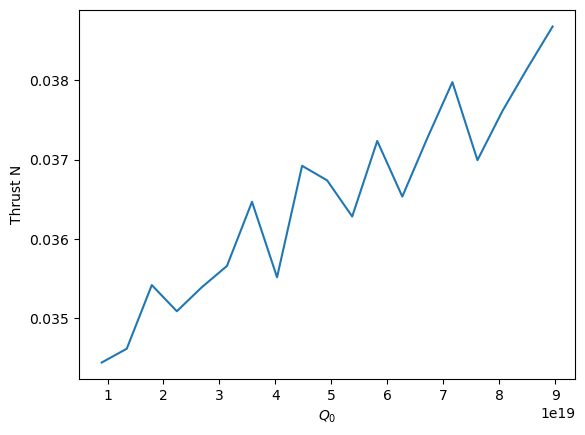

In [17]:
mass_flow_range = np.arange(200,10,-10)
Q = [sccm_to_persecond(i) for i in mass_flow_range]
plt.plot(Q,df_argon['Total_Thrust'])  
plt.ylabel('Thrust N')
plt.xlabel('$Q_0$')
plt.show()

### 5) Comment all the above results and use them to evaluate the best propellant for plasma propulsion.

Au vu du comportement hératique pour l'argon et le krypton en ce qui concerne les valeurs de poussée, il est clair que le meilleur choix est le xenon. Il en est de même pour le thrust-to-power ratio. Le Xenon est aussi le gaz qui présente la plus forte poussé pour un débit massique $Q_0$ donné. A l'opposé, le krypton est le gaz le moins efficace.